In [1]:
import os
import shutil # move files and delete folders with files
import tarfile
import urllib.request # download files folder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import IPython.display as ipd
import librosa, librosa.display
import re
import IPython # listen to sounds on Python
import pretty_midi

from scipy.io import wavfile
from scipy.spatial import distance_matrix
from matplotlib import colors
from itertools import product
from hmmlearn import hmm
from sklearn.metrics import f1_score
from utils.annotations import read_simplify_chord_file, simplify_predicted_chords, get_chord_notes, create_simple_midi
from utils.hmm_helper import calc_transition_prob_matrix, \
                             get_mu_sigma_from_chroma, \
                             create_ISPM,\
                             get_hmm_predictions, \
                             calc_initial_state_prob_matrix, \
                             adapt_initial_prob_matrix
from utils.files_processing import download_uncompress_data_to_local, \
                                   filter_lab_files, \
                                   delete_download_file, \
                                   delete_download_folder
from utils.signal import plot_signal, \
                         plot_spectra, \
                         stft_audio, \
                         calc_chromagram, \
                         chromagram_2_dataframe, \
                         get_frame_stats, \
                         get_annotated_chord_sequence, \
                         smooth_chords_by_beat
from utils.evaluation import calc_classification_stats, plot_performance


%load_ext autoreload
%autoreload 2


In [2]:
s_3, Fs_3 = librosa.load('over_the_rainbow.mp3')

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


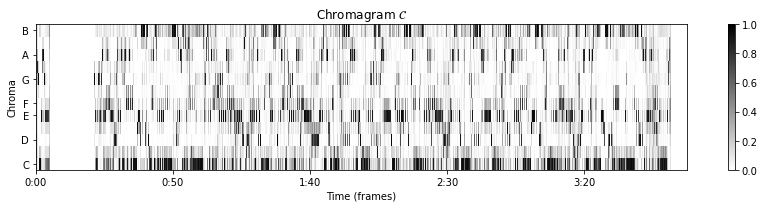

In [3]:
C = librosa.feature.chroma_stft(y=s_3, sr=Fs_3, tuning=0, norm=2, hop_length=1024, n_fft=4096)
plt.figure(figsize=(12, 3))
plt.title('Chromagram $\mathcal{C}$')
librosa.display.specshow(C, x_axis='time', y_axis='chroma', cmap='gray_r', hop_length=1024)
plt.xlabel('Time (frames)'); plt.ylabel('Chroma')
plt.colorbar(); plt.clim([0, 1])
plt.tight_layout()

In [4]:
def build_chroma(song_path, process_silence=True, test_version=False):

    # input data -> signal, sample frequency, chromagram and annotated dataset
    x2, Fs2 = librosa.load(song_path)
    C2 = calc_chromagram(x2, Fs2, False)
    frames_per_sec, frame_duration_sec = get_frame_stats(C2, x2, Fs2)
    annotation_file_path = f"{song_path.split('.')[0]}.lab"
    chords_annotation2 = read_simplify_chord_file(annotation_file_path,process_silence=process_silence)

    pcp2 = chromagram_2_dataframe(C2, frame_duration_sec, test_version=test_version)
    pcp2['chord'] = get_annotated_chord_sequence(pcp2, chords_annotation2, test_version=test_version)
    return x2, Fs2, pcp2

def calc_hmm_matrices(chromagram, process_silence=True, test_version=False):

    ##### HMM parameters
    # Transition Matrix
    transition_matrix2 = calc_transition_prob_matrix(chromagram, test_version=test_version)
    # Adapted Initial Probability Matrix
    init_states2 = calc_initial_state_prob_matrix(process_silence=process_silence, annotations_folder_path='lab_and_musics')
    filtered_initial_states2 = adapt_initial_prob_matrix(init_states2, transition_matrix2)
    # mu and covariance matrices
    mu_array2, states_cov_matrices2 = get_mu_sigma_from_chroma(chromagram)
    return filtered_initial_states2, transition_matrix2, mu_array2, states_cov_matrices2

def get_predictions(h_markov_model, prediction_dict, song_path, test_version=False):
    # get predictions
    signal, sr, chromagram = build_chroma(song_path, process_silence=True, test_version=False)
    chord_ix_predictions2 = h_markov_model.predict(chromagram[COL_NAMES_NOTES])

    chromagram['predicted'] = get_hmm_predictions(chord_ix_predictions2, prediction_dict)
    chromagram['predicted_cluster'] = smooth_chords_by_beat(chromagram, signal, sr, predicted_col='predicted', n_beats=1)
    return chromagram

def evaluate(chromagram, only_f1=False):
    return calc_classification_stats(chromagram, predicted_col='predicted_cluster', only_f1=only_f1)

def build_gaussian_hmm(initial_state_prob, transition_matrix, mu_array, states_cov_matrices):
    # continuous emission model
    h_markov_model = hmm.GaussianHMM(n_components=transition_matrix.shape[0], covariance_type="full")

    # initial state probability
    h_markov_model.startprob_ = initial_state_prob
    # transition matrix probability
    h_markov_model.transmat_ = transition_matrix.values

    # part of continuous emission probability - multidimensional gaussian
    # 12 dimensional mean vector
    h_markov_model.means_ = mu_array
    # array of covariance of shape [n_states, n_features, n_features]
    h_markov_model.covars_ = states_cov_matrices
    return h_markov_model


##### EXECUTION
def train_pipeline(songs, test_version=False):
    chromagram = pd.DataFrame()
    for song in songs:
        signal, sr, chromagram_one = build_chroma(song, test_version=test_version)
        chromagram = chromagram.append(chromagram_one, ignore_index=True)
    initial_states, transition_matrix, mu_array, states_cov_matrices = calc_hmm_matrices(chromagram, test_version=test_version)
    ix_2_chord = {ix_: chord_str for ix_,chord_str in zip(range(len(mu_array.index.values)),mu_array.index.values)}
    h_markov_model = build_gaussian_hmm(initial_states, transition_matrix, mu_array, states_cov_matrices)
    return h_markov_model, ix_2_chord


In [5]:
songs = []
for file_name in os.listdir('lab_and_musics'):
    if(file_name.endswith('.mp3')):
        songs.append(f'lab_and_musics/{file_name}')

h_markov_model, ix_2_chord = train_pipeline(songs)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


KeyboardInterrupt: 

In [8]:
def build_chroma_song(song_path, process_silence=True, test_version=False):

    # input data -> signal, sample frequency, chromagram and annotated dataset
    x2, Fs2 = librosa.load(song_path)
    C2 = calc_chromagram(x2, Fs2, False)
    frames_per_sec, frame_duration_sec = get_frame_stats(C2, x2, Fs2)
    
    pcp2 = chromagram_2_dataframe(C2, frame_duration_sec, test_version=test_version)
    return x2, Fs2, pcp2

def get_predictions_song(h_markov_model, prediction_dict, song_path, test_version=False):
    # get predictions
    signal, sr, chromagram = build_chroma_song(song_path, process_silence=True, test_version=False)
    chromagram.to_csv('chromagram.csv')
    chord_ix_predictions2 = h_markov_model.predict(chromagram[COL_NAMES_NOTES])
    print(chord_ix_predictions2)

    chromagram['predicted'] = get_hmm_predictions(chord_ix_predictions2, prediction_dict)
    chromagram['predicted_cluster'] = smooth_chords_by_beat(chromagram, signal, sr, predicted_col='predicted', n_beats=1)
    return chromagram

In [10]:
signal, sr, chromagram = build_chroma_song('temp.mp3', process_silence=True, test_version=False)
chromagram.to_csv('chromagram.csv')
    

In [7]:
COL_NAMES_NOTES = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
chromagram = get_predictions_song(h_markov_model, ix_2_chord, 'test.mp3')
chromagram.predicted

NameError: name 'h_markov_model' is not defined

In [ ]:
chromagram.head()

In [ ]:
chords_simplified = simplify_predicted_chords(chromagram)
chords_simplified

In [ ]:
x, Fs = librosa.load('over_the_rainbow.mp3')
create_simple_midi(chords_simplified, tempo=librosa.beat.tempo(x, Fs)[0])

In [ ]:
import datetime
import os
filePath = 'chord_subtitles.srt';
# As file at filePath is deleted now, so we should check if file exists or not not before deleting them
if os.path.exists(filePath):
    os.remove(filePath)
    
counter = 1
print(len(chords_simplified))
with open(filePath, 'a') as the_file:

    for idx, ch in chords_simplified.iterrows():
        the_file.write(str(counter) + '\n')
        
        seconds = ch['start']
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)

        start_time = "%02d:%02d:%02d"%(hours,minutes,seconds)
        number_dec = str(ch['start']-int(ch['start']))[2:4]
        start_time = start_time + ',' + number_dec

        seconds = ch['end']
        minutes, seconds = divmod(seconds, 60)
        hours, minutes = divmod(minutes, 60)

        end_time = "%02d:%02d:%02d"%(hours,minutes,seconds)
        number_dec = str(ch['end']-int(ch['end']))[2:4]
        end_time = end_time + ',' + number_dec

        the_file.write(start_time + ' --> ' + end_time + '\n')
        if (idx < len(chords_simplified)-1):
            chord_row = str(ch['predicted'] + '        Next: ' + chords_simplified.iloc[idx + 1]['predicted'] + '\n')
            the_file.write(chord_row)
        else:
            the_file.write(ch['predicted'] + '\n')
        the_file.write('\n')

        counter = counter + 1
